In [3]:
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import time

In [240]:
class BaseOptimizer:
    def __init__(self, lr, k_reg):
        self.lr = lr
        self.k_reg = k_reg

    def optimize(self, weights, loss_grad, batch_xs, batch_ys):
        gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
        return weights - gradient * self.lr + self.k_reg * weights

    def reset(self):
        pass


class BatchGD:
    def __init__(self, start_point, dim, epochs, loss, loss_grad, lamb=0.4, optimizer=BaseOptimizer(1e-2, 1e-4)):
        self.dim = dim
        self.epochs = epochs
        self.start_point = start_point
        self.weights = start_point
        self.loss = loss
        self.loss_grad = loss_grad
        self.lamb = lamb
        self.optimizer = optimizer
        self.trace_train = []
        self.trace = []

    def train(self, xs, ys, bs, q_precision=1e-5, weights_precision=1e-4, show_loss=True):
        q = self.loss(self.weights, xs, ys).mean()
        losses = []
        for i in range(self.epochs):
            batch_idxs = np.random.choice(np.arange(len(xs)), size=bs, replace=False)
            batch_xs = xs[batch_idxs, :]
            batch_ys = ys[batch_idxs]

            eps = self.loss(self.weights, batch_xs, batch_ys).mean()
            losses.append(q)
            prev_weights = self.weights
            self.trace_train.append(prev_weights)

            self.weights = self.optimizer.optimize(self.weights, self.loss_grad, batch_xs, batch_ys)

            prev_q = q
            q = self.lamb * eps + (1 - self.lamb) * prev_q

            if show_loss:
                print(f'Epoch: {i + 1}. Loss: {q}')

            if np.abs(q - prev_q) < q_precision and np.abs(self.weights - prev_weights).mean() < weights_precision:
                self.trace = np.array(self.trace_train)
                return losses
        self.trace = np.array(self.trace_train)
        return losses

    def reset_weights(self):
         self.weights = self.start_point
         self.trace_train = []
         self.trace = []
         self.optimizer.reset()

    def predict(self, xs):
        return xs @ self.weights

In [278]:
def plot3D(algo, label, show=True):
    w1, w2 = np.mgrid[-3*np.pi:3*np.pi:100j,
                -3*np.pi:3*np.pi:100j]
    w1, w2 = w1.reshape(-1, 1), w2.reshape(-1, 1)
    weights = np.append(w1, w2, axis=1).T
    answers = np.tile(ys.reshape(-1, 1), (1, 10000))
    z = loss(weights, xs, answers).mean(axis=0)

    w1 = w1.reshape(100, 100)
    w2 = w2.reshape(100, 100)
    z = z.reshape(100, 100)

    fig, ax = plt.subplots()

    ax.contour(w1, w2, z, levels=100)

    fig.set_figwidth(8)
    fig.set_figheight(8)

    plt.plot(algo.trace[:, 0], algo.trace[:, 1], '-o', label=label)
    plt.legend()

    if show:
        plt.show()

In [242]:
f = lambda x: -5 * x[:, 0] + 3 * x[:, 1]
loss = lambda weights, xs, ys: (xs @ weights - ys) ** 2
loss_grad = lambda weights, xs, ys: np.array([2 * (xs @ weights - ys) * (xs[:, i]) for i in range(len(weights))])

In [243]:
a, b = -10, 10
xs = (b - a) * np.random.random_sample((200, 2)) + a
ys = f(xs).flatten()

In [244]:
start_point = np.array([0, 0])

### SGD

In [245]:
sgd_algo = BatchGD(start_point, 2, 1000, loss, loss_grad)

In [246]:
sgd_losses = sgd_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1160.8761045912604
Epoch: 2. Loss: 817.4056198497188
Epoch: 3. Loss: 530.093325949556
Epoch: 4. Loss: 376.30180145750677
Epoch: 5. Loss: 245.26432216557586
Epoch: 6. Loss: 197.5733765603656
Epoch: 7. Loss: 205.6639716068505
Epoch: 8. Loss: 257.54555111213955
Epoch: 9. Loss: 175.68930753650955
Epoch: 10. Loss: 110.55719495913115
Epoch: 11. Loss: 72.60422339076075
Epoch: 12. Loss: 155.39467531528362
Epoch: 13. Loss: 93.33706297070906
Epoch: 14. Loss: 162.45231267048092
Epoch: 15. Loss: 101.45001449224088
Epoch: 16. Loss: 70.20463044652875
Epoch: 17. Loss: 42.53008409963609
Epoch: 18. Loss: 40.449795374299356
Epoch: 19. Loss: 42.809340444511825
Epoch: 20. Loss: 36.53488058416377
Epoch: 21. Loss: 40.02407898325819
Epoch: 22. Loss: 44.87149501447096
Epoch: 23. Loss: 75.66871605209276
Epoch: 24. Loss: 49.940313328246276
Epoch: 25. Loss: 34.760455021768784
Epoch: 26. Loss: 26.994300640452508
Epoch: 27. Loss: 16.28407109169738
Epoch: 28. Loss: 9.958842724108328
Epoch: 29. Loss:

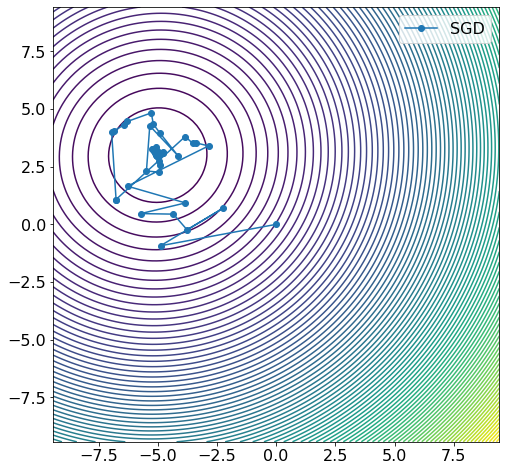

In [247]:
plot3D(sgd_algo, 'SGD')

In [248]:
sgd_algo.weights

array([-5.00182851,  2.99934359])

### Minibatch (20)

In [249]:
minibatch_algo = BatchGD(start_point, 2, 1000, loss, loss_grad)

In [250]:
minibatch_losses = minibatch_algo.train(xs, ys, bs=40)

Epoch: 1. Loss: 1123.559832469924
Epoch: 2. Loss: 764.2172425818887
Epoch: 3. Loss: 465.55485046386934
Epoch: 4. Loss: 279.71178824264655
Epoch: 5. Loss: 167.84580330658045
Epoch: 6. Loss: 100.7085725275749
Epoch: 7. Loss: 60.425311371268826
Epoch: 8. Loss: 36.255228812348555
Epoch: 9. Loss: 21.753145744906185
Epoch: 10. Loss: 13.051891877159935
Epoch: 11. Loss: 7.831147211756725
Epoch: 12. Loss: 4.698698707604028
Epoch: 13. Loss: 2.8192291434757433
Epoch: 14. Loss: 1.6915444388551713
Epoch: 15. Loss: 1.014938729675897
Epoch: 16. Loss: 0.6089717212488504
Epoch: 17. Loss: 0.36539230125771655
Epoch: 18. Loss: 0.21924558604856717
Epoch: 19. Loss: 0.1315564186134977
Epoch: 20. Loss: 0.07894712378193167
Epoch: 21. Loss: 0.04737484210593941
Epoch: 22. Loss: 0.028438275130049075
Epoch: 23. Loss: 0.017070385823027178
Epoch: 24. Loss: 0.010248257267789985
Epoch: 25. Loss: 0.006154646678828461
Epoch: 26. Loss: 0.003697609066946971
Epoch: 27. Loss: 0.002229629126239338
Epoch: 28. Loss: 0.00134751

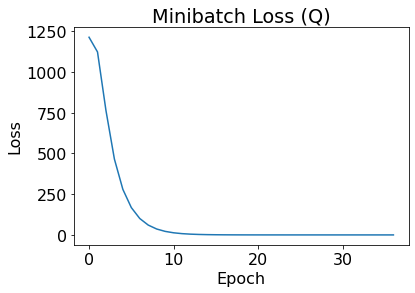

In [251]:
plt.plot(minibatch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Minibatch Loss (Q)')
plt.show()

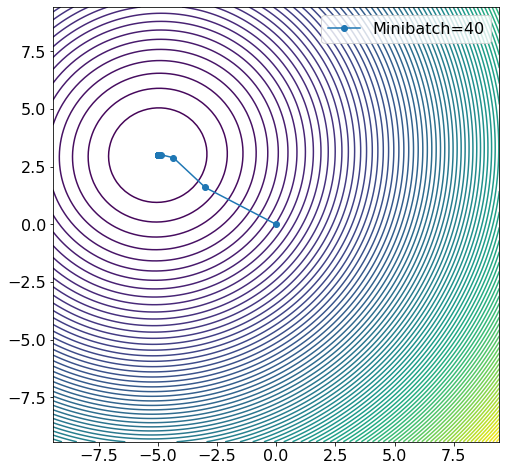

In [252]:
plot3D(minibatch_algo, 'Minibatch=40')

### Batch (full dataset)

In [253]:
batch_algo = BatchGD(start_point, 2, 1000, loss, loss_grad, 1.0)

In [254]:
batch_losses = batch_algo.train(xs, ys, bs=100)

Epoch: 1. Loss: 1153.2336522644343
Epoch: 2. Loss: 134.97488912610933
Epoch: 3. Loss: 8.512795414254885
Epoch: 4. Loss: 0.6828972110717879
Epoch: 5. Loss: 0.03098852028516086
Epoch: 6. Loss: 0.0026537493102945543
Epoch: 7. Loss: 5.698646676301251e-05
Epoch: 8. Loss: 3.793102581878763e-06
Epoch: 9. Loss: 1.5422591024556053e-05
Epoch: 10. Loss: 2.314423807793774e-05


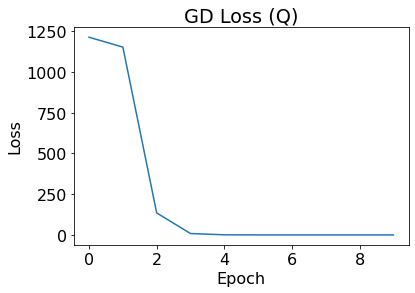

In [255]:
plt.plot(batch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GD Loss (Q)')
plt.show()

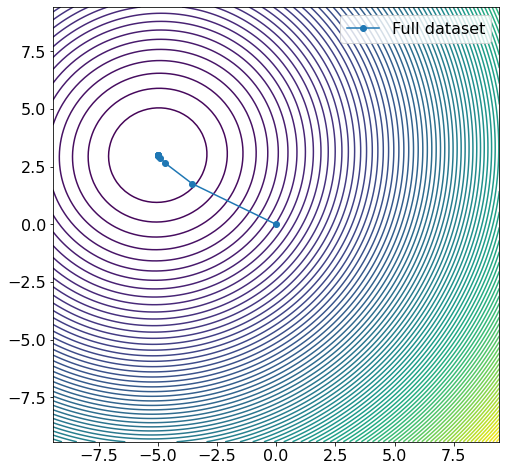

In [256]:
plot3D(batch_algo, 'Full dataset')

In [257]:
scaled = xs.copy()
scaled[:, 0] = (scaled[:, 0] - scaled[:, 0].mean(axis=0)) / scaled[:, 0].std(axis=0)
ys_scaled = f(scaled).flatten()

In [258]:
sgd_algo_scaled = BatchGD(start_point, 2, 1000, loss, loss_grad)
sgd_losses_scaled = sgd_algo_scaled.train(scaled, ys_scaled, 1)

Epoch: 1. Loss: 231.5641759412953
Epoch: 2. Loss: 187.74301805598483
Epoch: 3. Loss: 115.62775051243308
Epoch: 4. Loss: 95.0459958901993
Epoch: 5. Loss: 78.64520559358022
Epoch: 6. Loss: 55.32409860513685
Epoch: 7. Loss: 33.19566597418649
Epoch: 8. Loss: 43.84132982619005
Epoch: 9. Loss: 27.799702666016188
Epoch: 10. Loss: 28.258975679523857
Epoch: 11. Loss: 30.565380893203887
Epoch: 12. Loss: 31.971318054961124
Epoch: 13. Loss: 19.789359960876872
Epoch: 14. Loss: 15.862437041380783
Epoch: 15. Loss: 9.65258142182861
Epoch: 16. Loss: 5.9090854618718955
Epoch: 17. Loss: 22.40970878926751
Epoch: 18. Loss: 13.813626587514399
Epoch: 19. Loss: 27.361134642820268
Epoch: 20. Loss: 32.840565743519655
Epoch: 21. Loss: 34.794465101541775
Epoch: 22. Loss: 29.477635269364605
Epoch: 23. Loss: 17.88526824877231
Epoch: 24. Loss: 11.46297430963789
Epoch: 25. Loss: 10.233433388558968
Epoch: 26. Loss: 25.321364854408
Epoch: 27. Loss: 16.81047960486413
Epoch: 28. Loss: 10.282910650050777
Epoch: 29. Loss: 

Text(0.5, 1.0, 'SGD Loss (Scaled) (Q)')

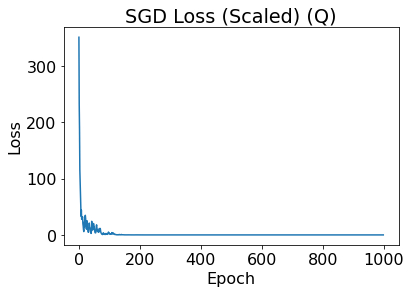

In [259]:
plt.plot(sgd_losses_scaled)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Scaled) (Q)')

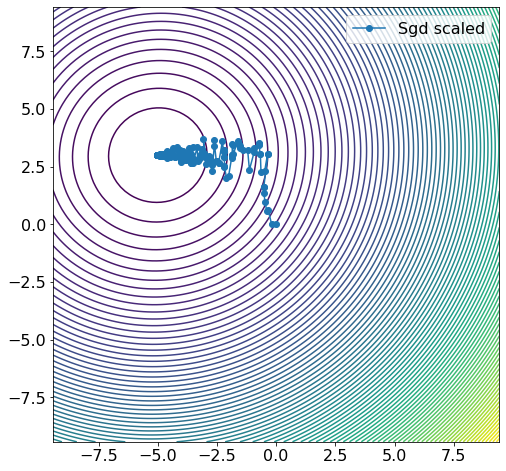

In [260]:
plot3D(sgd_algo_scaled, 'Sgd scaled')

## Nesterov 

In [261]:
class NesterovOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights - self.gamma * self.v, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v
  def reset(self):
        self.v = 0

optimizer = NesterovOptimizer()
sgd_nesterov_algo = BatchGD(start_point, 2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_nesterov_losses = sgd_nesterov_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1131.512642305694
Epoch: 2. Loss: 1098.8471355631125
Epoch: 3. Loss: 1266.5307957072678
Epoch: 4. Loss: 787.5183877787844
Epoch: 5. Loss: 634.4273532998507
Epoch: 6. Loss: 412.51992590901466
Epoch: 7. Loss: 257.5655562559412
Epoch: 8. Loss: 180.26784171395556
Epoch: 9. Loss: 169.7788928525131
Epoch: 10. Loss: 282.1773210660204
Epoch: 11. Loss: 356.77651176225913
Epoch: 12. Loss: 218.7354297975527
Epoch: 13. Loss: 132.39207584738082
Epoch: 14. Loss: 79.44181505575715
Epoch: 15. Loss: 65.56234242304221
Epoch: 16. Loss: 50.76390215966937
Epoch: 17. Loss: 43.5403448202898
Epoch: 18. Loss: 26.808344193584183
Epoch: 19. Loss: 30.363019471962694
Epoch: 20. Loss: 33.35426517216408
Epoch: 21. Loss: 66.08914328985485
Epoch: 22. Loss: 56.35642597086809
Epoch: 23. Loss: 34.07477654141762
Epoch: 24. Loss: 21.0027238151897
Epoch: 25. Loss: 18.276133589389126
Epoch: 26. Loss: 11.140373951157303
Epoch: 27. Loss: 8.14674828849449
Epoch: 28. Loss: 6.1032764725798305
Epoch: 29. Loss: 33.0

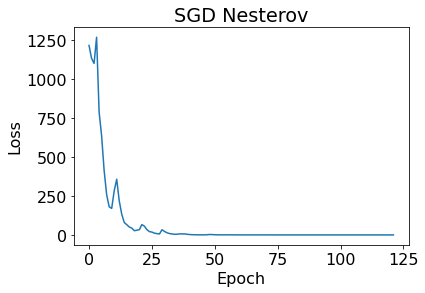

In [262]:
plt.plot(sgd_nesterov_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Nesterov')
plt.show()

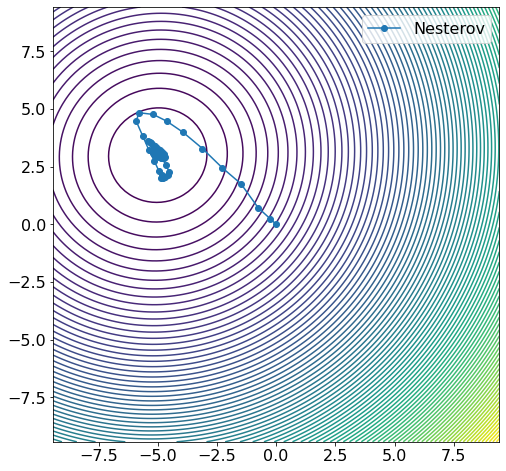

In [263]:
plot3D(sgd_nesterov_algo, 'Nesterov')

## Momentum

In [264]:
class MomentumOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v

  def reset(self):
      self.v = 0

optimizer = MomentumOptimizer()
sgd_momentum_algo = BatchGD(start_point, 2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_monentum_losses = sgd_momentum_algo.train(xs, ys, 1)

Epoch: 1. Loss: 748.7139147669785
Epoch: 2. Loss: 500.3701784484464
Epoch: 3. Loss: 2206.7237803758776
Epoch: 4. Loss: 1508.5793262911502
Epoch: 5. Loss: 968.6589208449316
Epoch: 6. Loss: 625.2124438435485
Epoch: 7. Loss: 438.21737007566463
Epoch: 8. Loss: 436.4549129997679
Epoch: 9. Loss: 282.189070166278
Epoch: 10. Loss: 196.5946165671748
Epoch: 11. Loss: 1388.9357434853202
Epoch: 12. Loss: 967.4905966547133
Epoch: 13. Loss: 717.7130471060624
Epoch: 14. Loss: 454.8795575559388
Epoch: 15. Loss: 841.1304879566395
Epoch: 16. Loss: 1072.4392342536134
Epoch: 17. Loss: 693.6140715336876
Epoch: 18. Loss: 421.12800196821746
Epoch: 19. Loss: 666.9823596990236
Epoch: 20. Loss: 1532.3379645899843
Epoch: 21. Loss: 981.7029740517405
Epoch: 22. Loss: 591.753521438744
Epoch: 23. Loss: 509.98334450137895
Epoch: 24. Loss: 683.6783685733735
Epoch: 25. Loss: 512.0626032681301
Epoch: 26. Loss: 431.56553287763944
Epoch: 27. Loss: 298.94541326228835
Epoch: 28. Loss: 202.52094722076794
Epoch: 29. Loss: 151

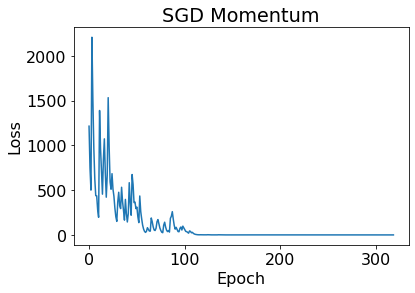

In [265]:
plt.plot(sgd_monentum_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Momentum')
plt.show()

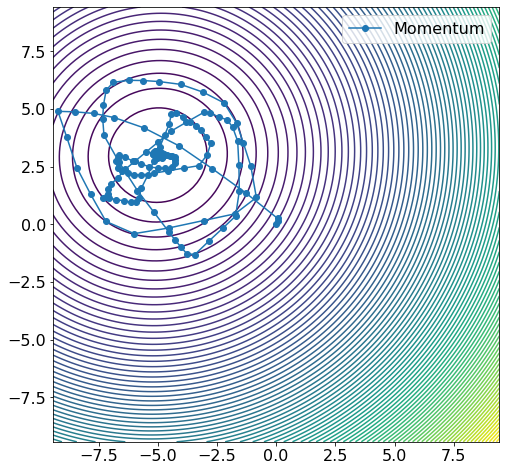

In [266]:
plot3D(sgd_momentum_algo, 'Momentum')

## AdaGrad

In [267]:
%%time
class AdaGradOptimizer:
  def __init__(self,lr=9e-1, eps = 1e-8):
    self.G = 0
    self.lr = lr
    self.eps = eps

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G += gradient ** 2
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

  def reset(self):
      self.G = 0

optimizer = AdaGradOptimizer()
sgd_adagrad_algo = BatchGD(start_point, 2, 20000, loss, loss_grad, lamb=0.8, optimizer=optimizer)

sgd_adagrad_losses = sgd_adagrad_algo.train(xs, ys, 1)

Epoch: 1. Loss: 2043.9720279656794
Epoch: 2. Loss: 448.10598320078134
Epoch: 3. Loss: 688.0892426885501
Epoch: 4. Loss: 2148.405948446041
Epoch: 5. Loss: 430.9793161302356
Epoch: 6. Loss: 486.1743269893607
Epoch: 7. Loss: 242.16319784118872
Epoch: 8. Loss: 428.7614054108311
Epoch: 9. Loss: 321.85180734195643
Epoch: 10. Loss: 331.6313616394677
Epoch: 11. Loss: 128.12318295878373
Epoch: 12. Loss: 84.80815069759544
Epoch: 13. Loss: 195.96796690530456
Epoch: 14. Loss: 101.12305432694342
Epoch: 15. Loss: 49.48171102353258
Epoch: 16. Loss: 44.84786508989064
Epoch: 17. Loss: 10.038355765532678
Epoch: 18. Loss: 28.006660974547845
Epoch: 19. Loss: 7.072980533805723
Epoch: 20. Loss: 27.05957575697427
Epoch: 21. Loss: 164.67654110127725
Epoch: 22. Loss: 550.4395833844014
Epoch: 23. Loss: 110.26345817181638
Epoch: 24. Loss: 75.94429735582065
Epoch: 25. Loss: 64.56670728143915
Epoch: 26. Loss: 15.529443872129656
Epoch: 27. Loss: 52.524745573730065
Epoch: 28. Loss: 11.038122595779592
Epoch: 29. Loss

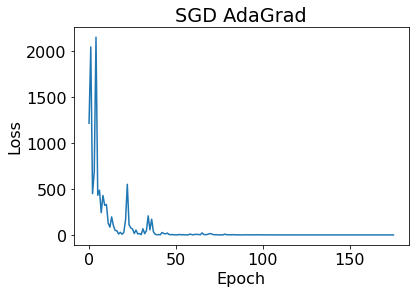

In [268]:
plt.plot(sgd_adagrad_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD AdaGrad')
plt.show()

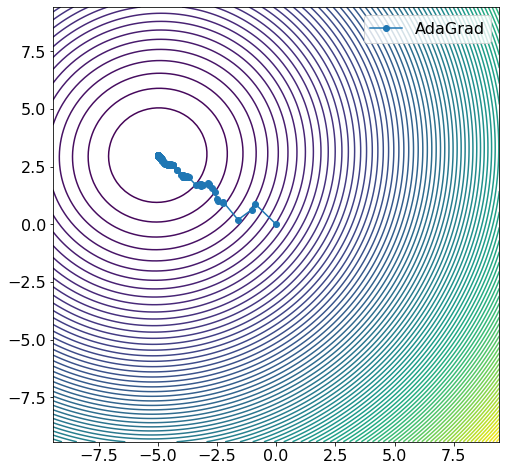

In [269]:
plot3D(sgd_adagrad_algo, 'AdaGrad')

## RMSProp

In [270]:
%%time
class RMSPropOptimizer:
  def __init__(self,lr=1e-1, eps = 1e-7, gamma=0.9):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G = self.G * self.gamma + (1 - self.gamma) * (gradient ** 2)
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

  def reset(self):
      self.G = 0

optimizer = RMSPropOptimizer()
sgd_rmsprop_algo = BatchGD(start_point, 2, 20000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_rmsprop_losses = sgd_rmsprop_algo.train(xs, ys, 1)

Epoch: 1. Loss: 897.9007532825854
Epoch: 2. Loss: 542.9445636627473
Epoch: 3. Loss: 391.06646678145376
Epoch: 4. Loss: 464.3048189077949
Epoch: 5. Loss: 883.2886360258212
Epoch: 6. Loss: 683.643750422736
Epoch: 7. Loss: 565.6876235439537
Epoch: 8. Loss: 719.3898532832948
Epoch: 9. Loss: 433.78728732798163
Epoch: 10. Loss: 1716.7272050578167
Epoch: 11. Loss: 1295.9922440094974
Epoch: 12. Loss: 1343.7928058849266
Epoch: 13. Loss: 828.0966741179695
Epoch: 14. Loss: 1479.1709784566465
Epoch: 15. Loss: 969.8806318718086
Epoch: 16. Loss: 602.0433064542475
Epoch: 17. Loss: 402.32587201952225
Epoch: 18. Loss: 251.95934927477455
Epoch: 19. Loss: 151.91921980646322
Epoch: 20. Loss: 119.65547535133848
Epoch: 21. Loss: 297.0649441876909
Epoch: 22. Loss: 254.52094328852348
Epoch: 23. Loss: 370.75890452064135
Epoch: 24. Loss: 659.633164797996
Epoch: 25. Loss: 472.5522403873609
Epoch: 26. Loss: 641.141664054459
Epoch: 27. Loss: 510.1821863354017
Epoch: 28. Loss: 602.2810472007618
Epoch: 29. Loss: 660

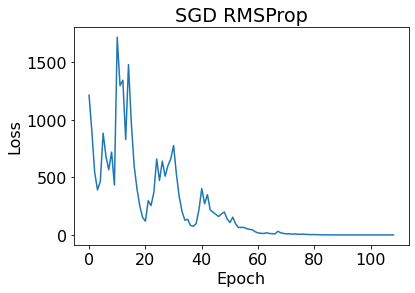

In [271]:
plt.plot(sgd_rmsprop_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD RMSProp')
plt.show()

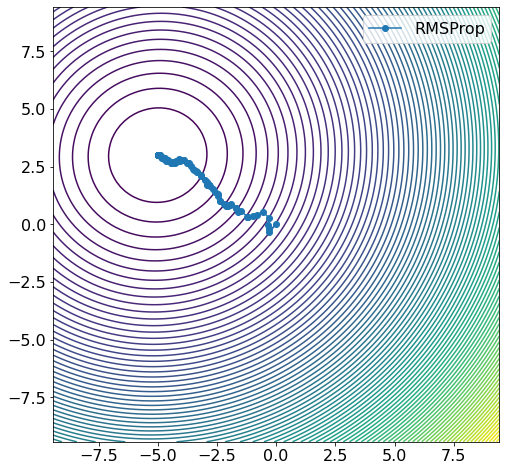

In [272]:
plot3D(sgd_rmsprop_algo, 'RMSProp')

## Adam

In [273]:
%%time
class AdamOptimizer:
  def __init__(self,lr=1e-2, eps = 1e-7, b_1=0.5, b_2=0.5):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.b_1 = b_1
    self.b_2 = b_2

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)

    self.m = self.G * self.b_1 + (1 - self.b_1) * gradient
    self.v = self.G * self.b_2 + (1 - self.b_2) * (gradient ** 2)

    return weights - self.lr * self.m / np.sqrt(self.v + self.eps)

  def reset(self):
      self.G = 0

optimizer = AdamOptimizer()
sgd_adam_algo = BatchGD(start_point, 2, 10000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_adam_losses = sgd_adam_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1686.6121318957232
Epoch: 2. Loss: 1046.641601192043
Epoch: 3. Loss: 1004.1427713595949
Epoch: 4. Loss: 1070.8996435912231
Epoch: 5. Loss: 689.4325647814846
Epoch: 6. Loss: 1845.5958255513324
Epoch: 7. Loss: 2383.954746785945
Epoch: 8. Loss: 1609.170500318135
Epoch: 9. Loss: 1109.4821123251118
Epoch: 10. Loss: 714.6755672077984
Epoch: 11. Loss: 1028.6871280565322
Epoch: 12. Loss: 966.8338077872703
Epoch: 13. Loss: 587.6724378067598
Epoch: 14. Loss: 2447.2366079032945
Epoch: 15. Loss: 3081.4553302917484
Epoch: 16. Loss: 1999.8228882968697
Epoch: 17. Loss: 2242.1434699906367
Epoch: 18. Loss: 1652.2760218955052
Epoch: 19. Loss: 1368.5202338251174
Epoch: 20. Loss: 924.6384605037005
Epoch: 21. Loss: 2145.058802609295
Epoch: 22. Loss: 1514.8007611394087
Epoch: 23. Loss: 1140.1249833581833
Epoch: 24. Loss: 1097.9776132256652
Epoch: 25. Loss: 738.2325747679894
Epoch: 26. Loss: 685.2587110154618
Epoch: 27. Loss: 582.181820134063
Epoch: 28. Loss: 359.1351321350909
Epoch: 29. Loss

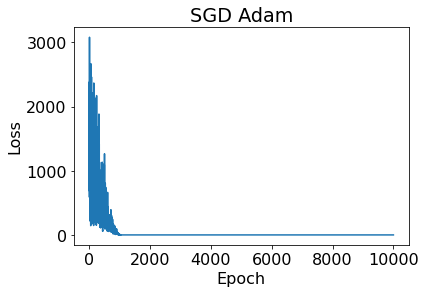

In [274]:
plt.plot(sgd_adam_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Adam')
plt.show()

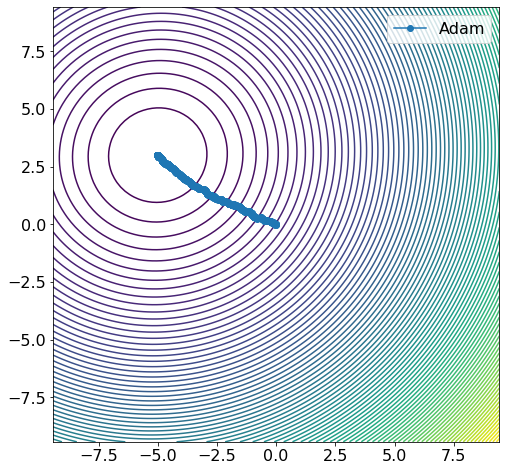

In [275]:
plot3D(sgd_adam_algo, 'Adam')

## Сравнение алгоритмов

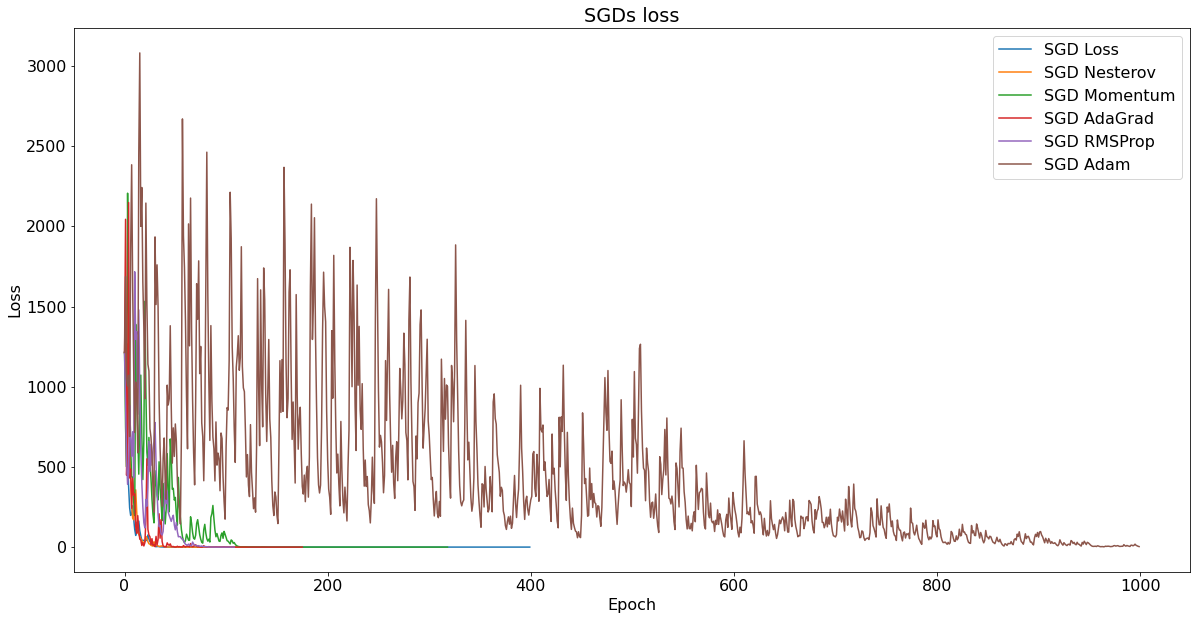

In [276]:
plt.figure(figsize=(20, 10))
plt.plot(sgd_losses, label='SGD Loss')
plt.plot(sgd_nesterov_losses, label='SGD Nesterov')
plt.plot(sgd_monentum_losses, label='SGD Momentum')
plt.plot(sgd_adagrad_losses, label='SGD AdaGrad')
plt.plot(sgd_rmsprop_losses, label='SGD RMSProp')
plt.plot(sgd_adam_losses[0:1000], label='SGD Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGDs loss')
plt.legend()
plt.show()

count iterations : [400, 122, 319, 176, 109, 1000]
used memory : [3302.56640625, 3302.56640625, 3302.56640625, 3302.56640625, 3302.56640625, 3302.56640625]
work time : [1.3090012073516846, 1.3239984512329102, 1.287998914718628, 1.2249982357025146, 1.2844030857086182, 0.0009984970092773438]


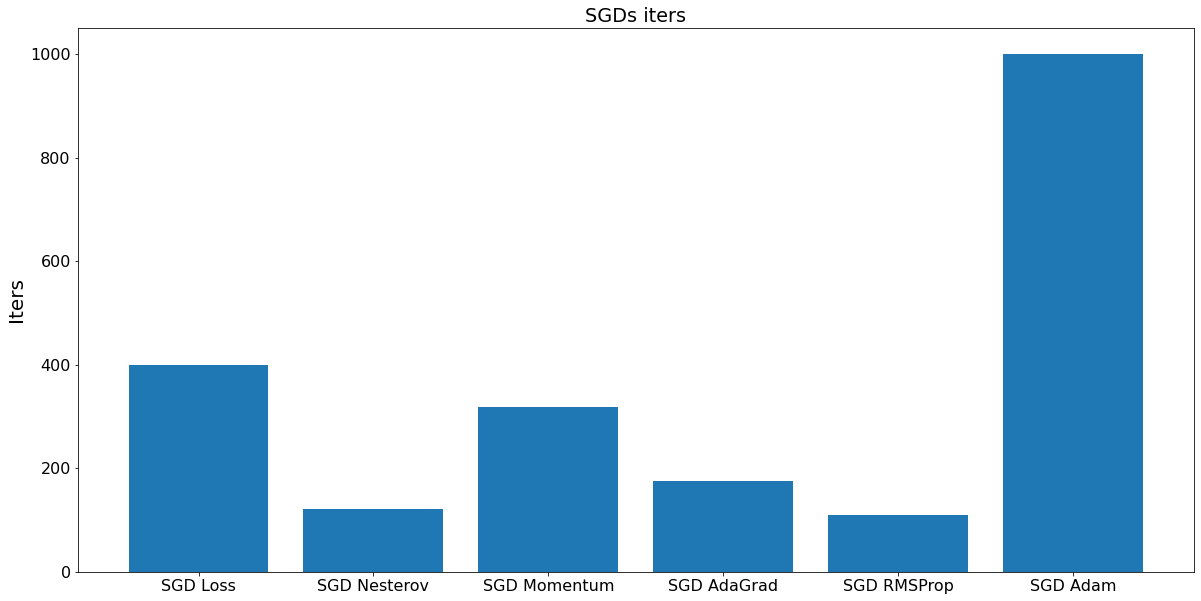

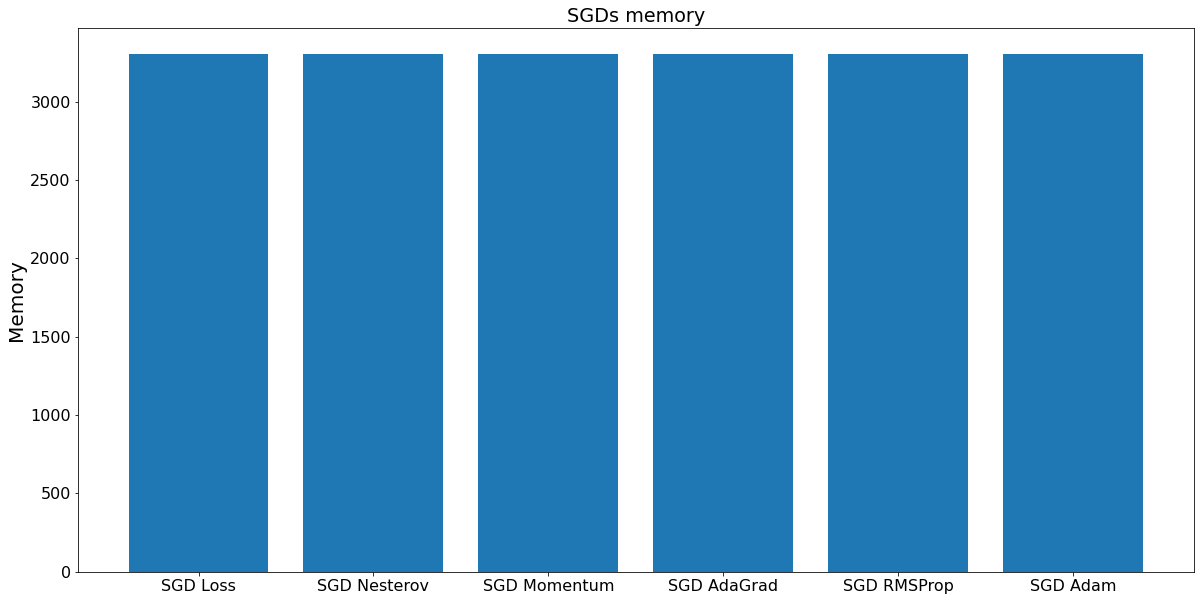

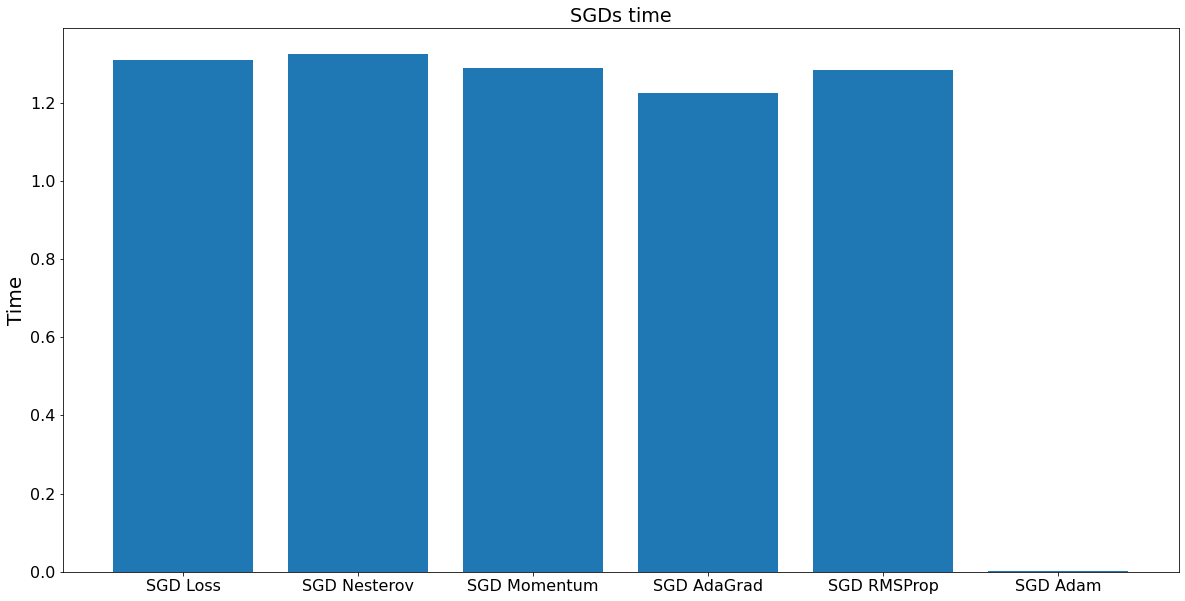

In [277]:
algos_names = ['SGD Loss', 'SGD Nesterov', 'SGD Momentum', 'SGD AdaGrad', 'SGD RMSProp', 'SGD Adam']
count_iters = [len(sgd_losses), len(sgd_nesterov_losses), len(sgd_monentum_losses), len(sgd_adagrad_losses),
               len(sgd_rmsprop_losses), len(sgd_adam_losses[0:1000])]
algos = [sgd_algo, sgd_nesterov_algo, sgd_momentum_algo, sgd_adagrad_algo, sgd_rmsprop_algo, sgd_adam_algo]
memories = []
times = []
for algo in algos:
    algo.reset_weights()
    cur_time = time.time()
    (memory, exe_time) = memory_usage((algo.train, (xs, ys, 1,), {'show_loss': False}), timestamps=True)[0]
    memories.append(memory)
    times.append(exe_time - cur_time)

plt.rcParams.update({'font.size': 16})

print('count iterations : ' + str(count_iters))
print('used memory : ' + str(memories))
print('work time : ' + str(times))

plt.figure(figsize=(20, 10))
plt.title('SGDs iters')
plt.ylabel('Iters', fontsize=20)
plt.bar(algos_names, count_iters)
plt.show()

plt.figure(figsize=(20, 10))
plt.title('SGDs memory')
plt.ylabel('Memory', fontsize=20)
plt.bar(algos_names, memories)
plt.show()

plt.figure(figsize=(20, 10))
plt.title('SGDs time')
plt.ylabel('Time', fontsize=20)
plt.bar(algos_names, times)
plt.show()

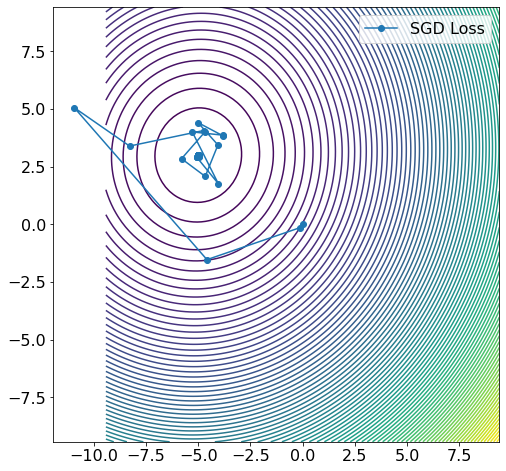

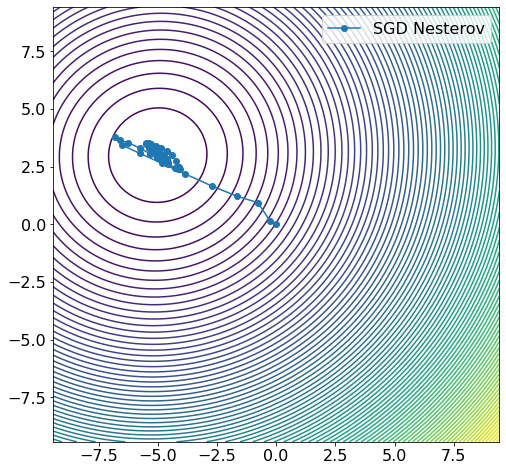

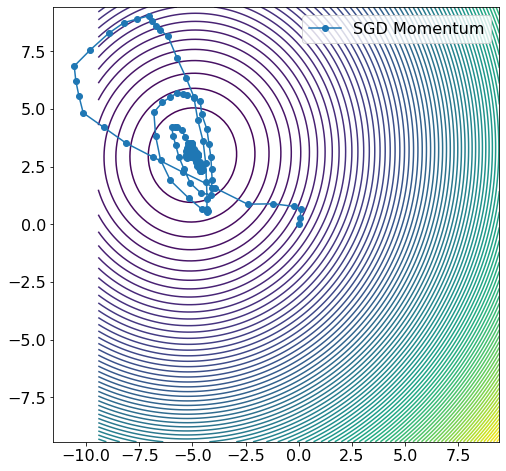

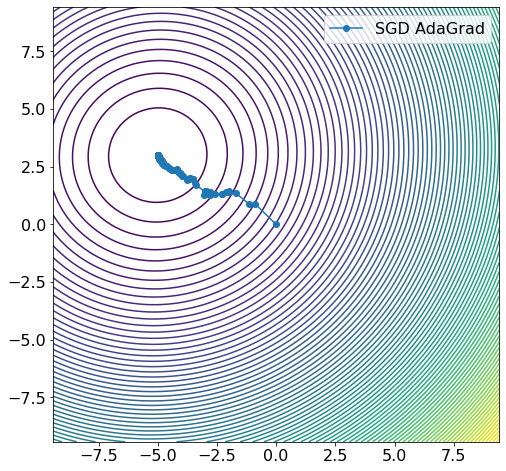

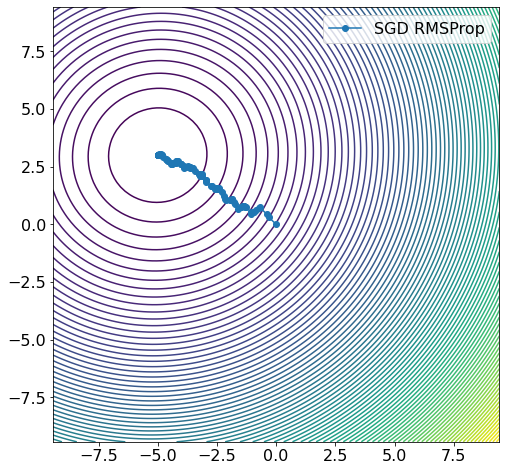

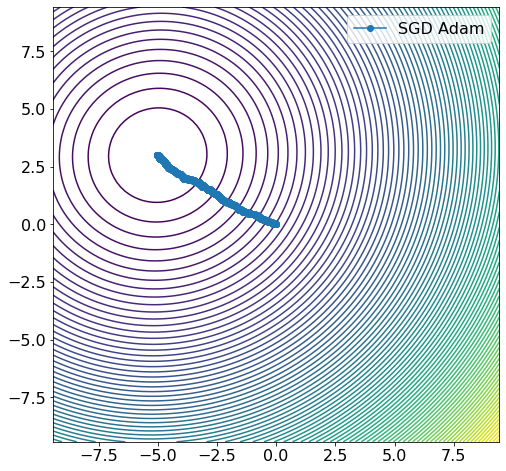

In [279]:
for algo, label in zip(algos, algos_names):
    plot3D(algo, label, False)
plt.show()